In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
# Better to run extraction on local machine
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

./notMNIST_large/A.pickle already present - Skipping pickling.
./notMNIST_large/B.pickle already present - Skipping pickling.
./notMNIST_large/C.pickle already present - Skipping pickling.
./notMNIST_large/D.pickle already present - Skipping pickling.
./notMNIST_large/E.pickle already present - Skipping pickling.
./notMNIST_large/F.pickle already present - Skipping pickling.
./notMNIST_large/G.pickle already present - Skipping pickling.
./notMNIST_large/H.pickle already present - Skipping pickling.
./notMNIST_large/I.pickle already present - Skipping pickling.
./notMNIST_large/J.pickle already present - Skipping pickling.
./notMNIST_small/A.pickle already present - Skipping pickling.
./notMNIST_small/B.pickle already present - Skipping pickling.
./notMNIST_small/C.pickle already present - Skipping pickling.
./notMNIST_small/D.pickle already present - Skipping pickling.
./notMNIST_small/E.pickle already present - Skipping pickling.
./notMNIST_small/F.pickle already present - Skipping pi

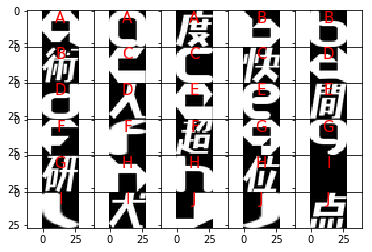

In [5]:
count = 0
f, a = plt.subplots(6, 5, sharey=True)
f.subplots_adjust(hspace = .001, wspace=.001)

for folder in train_folders:
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  for image in image_files[0:3]:
    image_file = os.path.join(folder, image)
    img = ndimage.imread(image_file)
    ax = a[int(round(count/5)),count%5]
    ax.set_title(image_file.split('large/')[1].\
                 split('/')[0],size=15, position=(0.5, 0.5), color='r')
    ax.imshow(img, cmap='gray')
    count = count + 1

plt.show()    

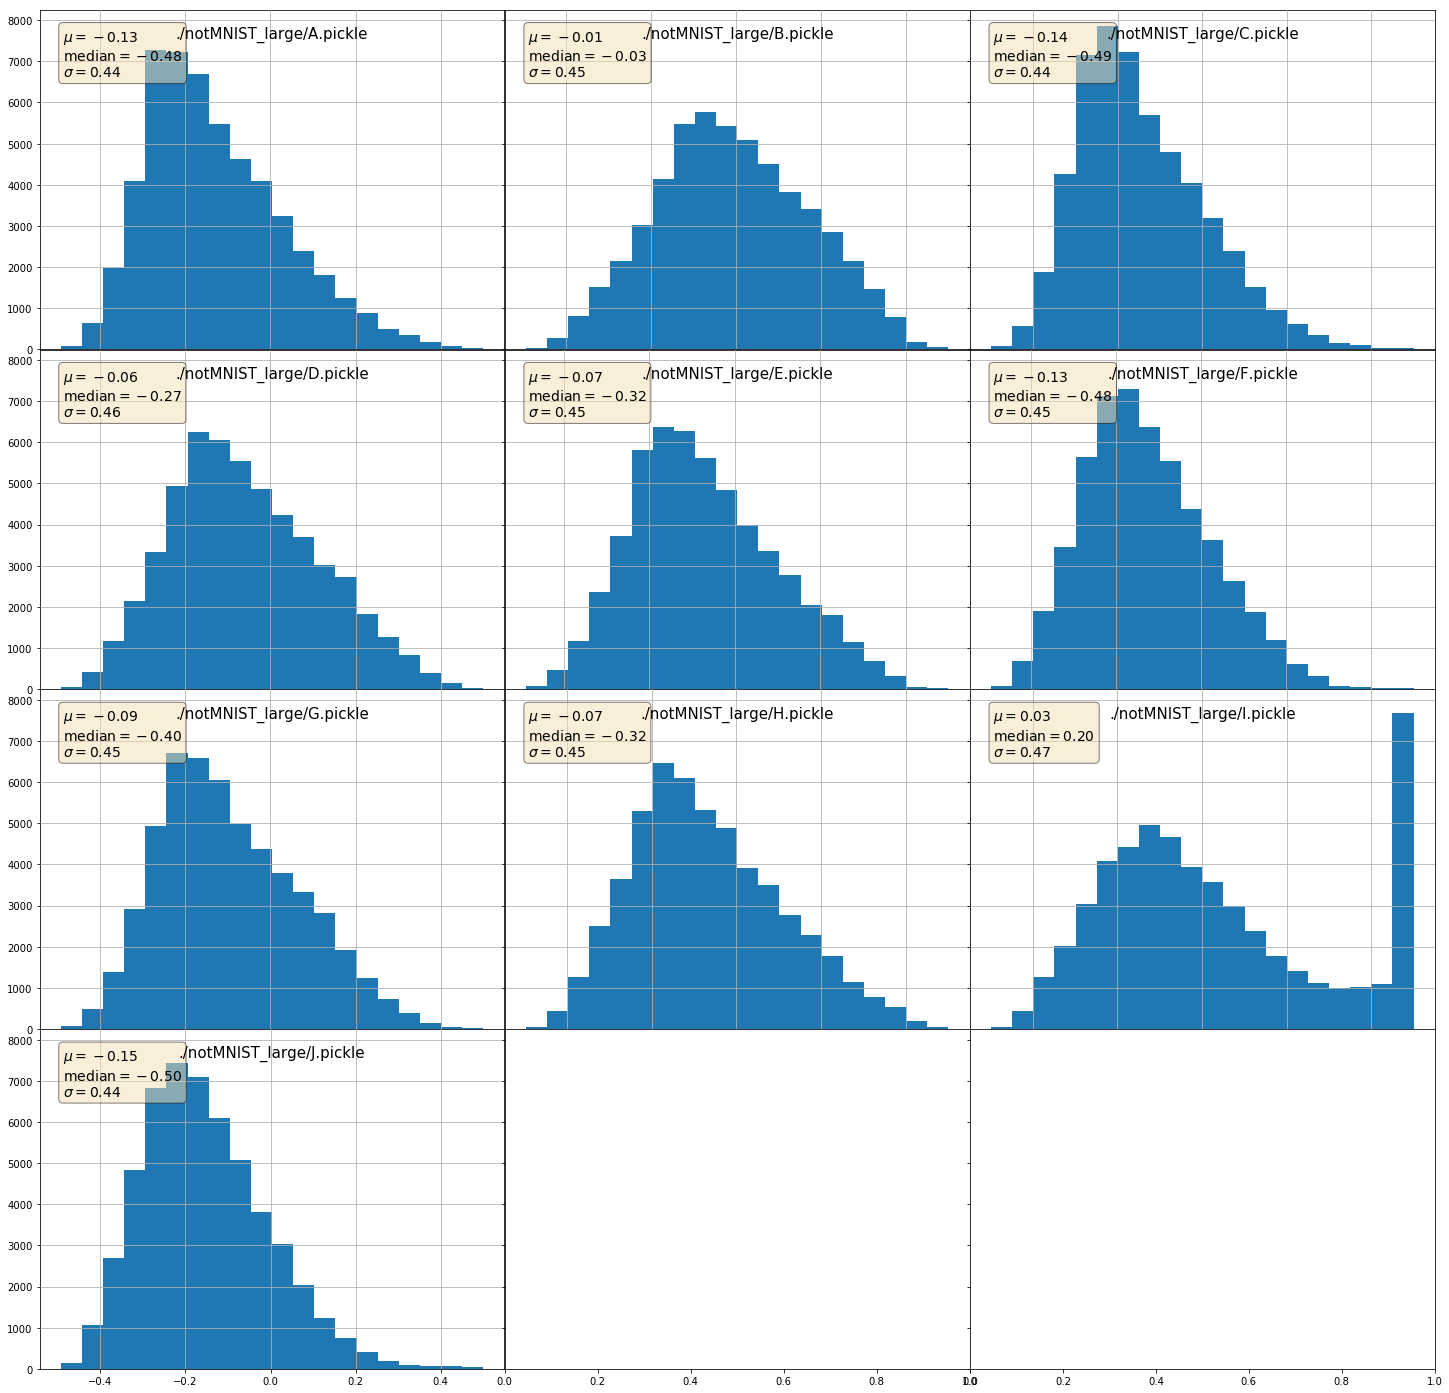

In [7]:
def plot_data(train_datasets):
    count = 0
    num_bins = 20
    f, a = plt.subplots(4, 3, figsize=(25,25), sharey=True)
    f.subplots_adjust(hspace = .001, wspace=.001)

    for label, pickle_file in enumerate(train_datasets):       
        data = []
        try:
          with open(pickle_file, 'rb') as f:
            data = pickle.load(f)

            mu = np.mean(data)
            median = np.median(data)
            sigma = np.std(data)

            textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$' \
                    % (mu, median, sigma)

            # these are matplotlib.patch.Patch properties
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

            ax = a[int(round(count/3)),count%3]
            ax.set_title(pickle_file,size=15, position=(0.5, 0.9))
            ax.hist([np.mean(arr) for arr in data],num_bins)

            # place a text box in upper left in axes coords
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', horizontalalignment='left', bbox=props)

            ax.grid()
            ax.set_axisbelow(False)

            count = count + 1
        except Exception as e:
            print('Unable to load data to', pickle_file, ':', e)

    plt.show()   

plot_data(train_datasets)    

In [8]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [9]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

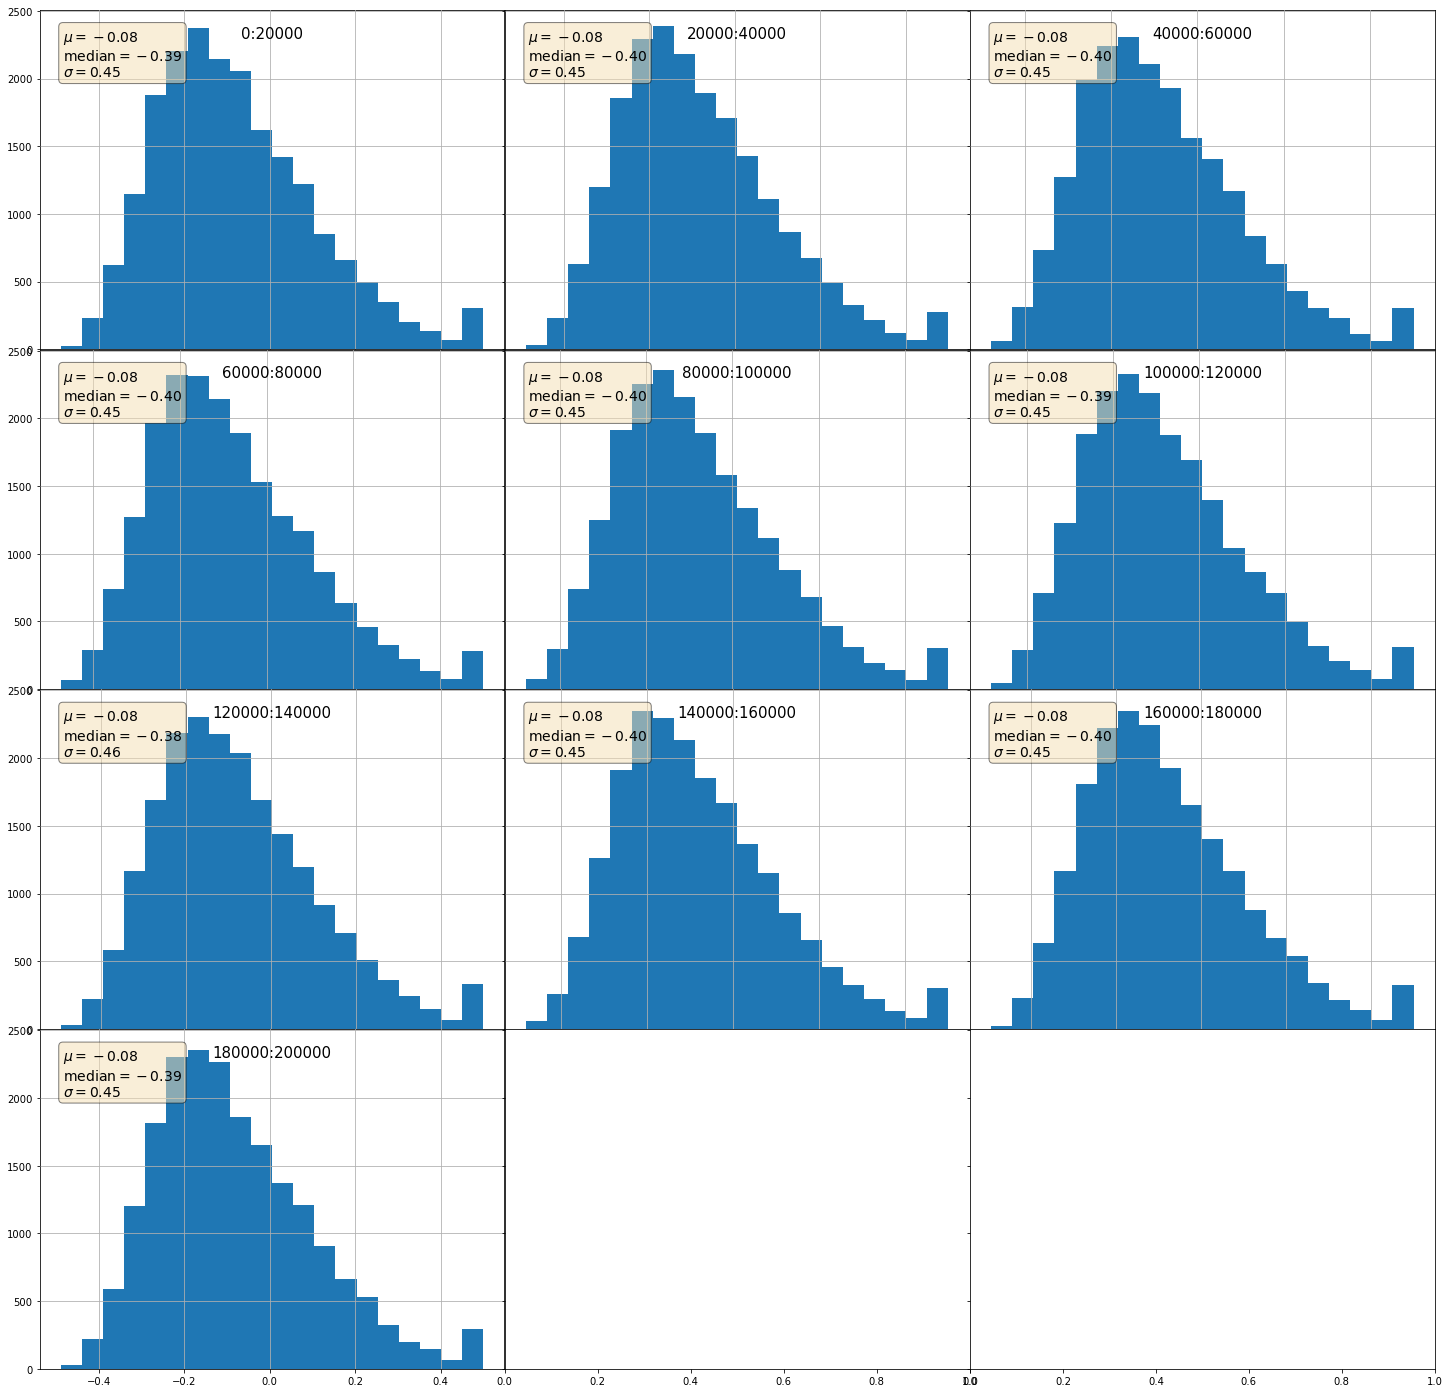

In [43]:
def plot_shuffle_data(size_per_class,dataset):
    num_bins = 20
    f1, a1 = plt.subplots(4, 3, figsize=(25,25), sharey=True)
    f1.subplots_adjust(hspace = .001, wspace=.001)
    data = []
    count = 0
    for i in range(10):
        data = dataset[size_per_class*i : size_per_class*(i+1), :, :]

        mu = np.mean(data)
        median = np.median(data)
        sigma = np.std(data)

        textstr = '$\mu=%.2f$\n$\mathrm{median}=%.2f$\n$\sigma=%.2f$' \
                % (mu, median, sigma)

        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

        ax = a1[int(round(count/3)),count%3]
        ax.set_title(str(tsize_per_class*i) +':' + str(tsize_per_class*(i+1)),size=15, position=(0.5, 0.9))
        ax.hist([np.mean(arr) for arr in data],num_bins)

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left', bbox=props)

        ax.grid()
        ax.set_axisbelow(False)

        count = count + 1
    plt.show()

tsize_per_class = train_size/10
plot_shuffle_data(tsize_per_class, train_dataset)   

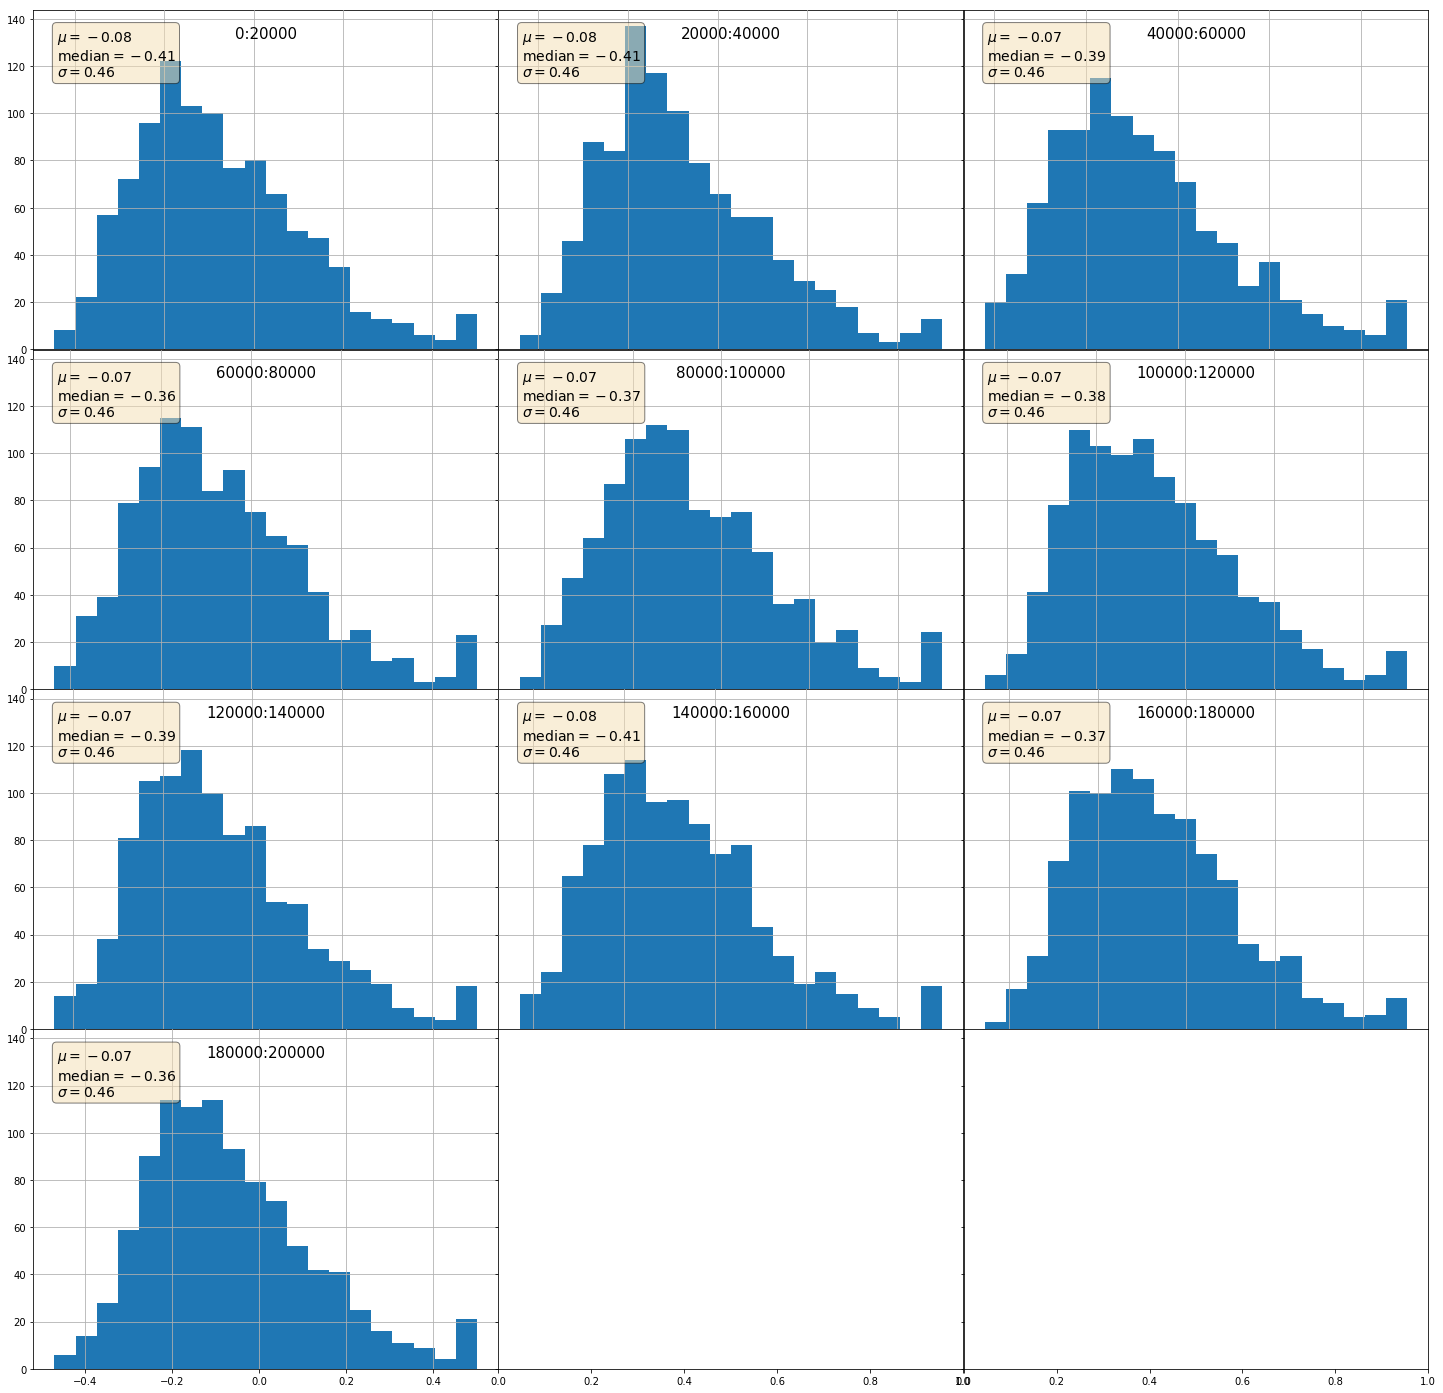

In [44]:
plot_shuffle_data(test_size/10, test_dataset)

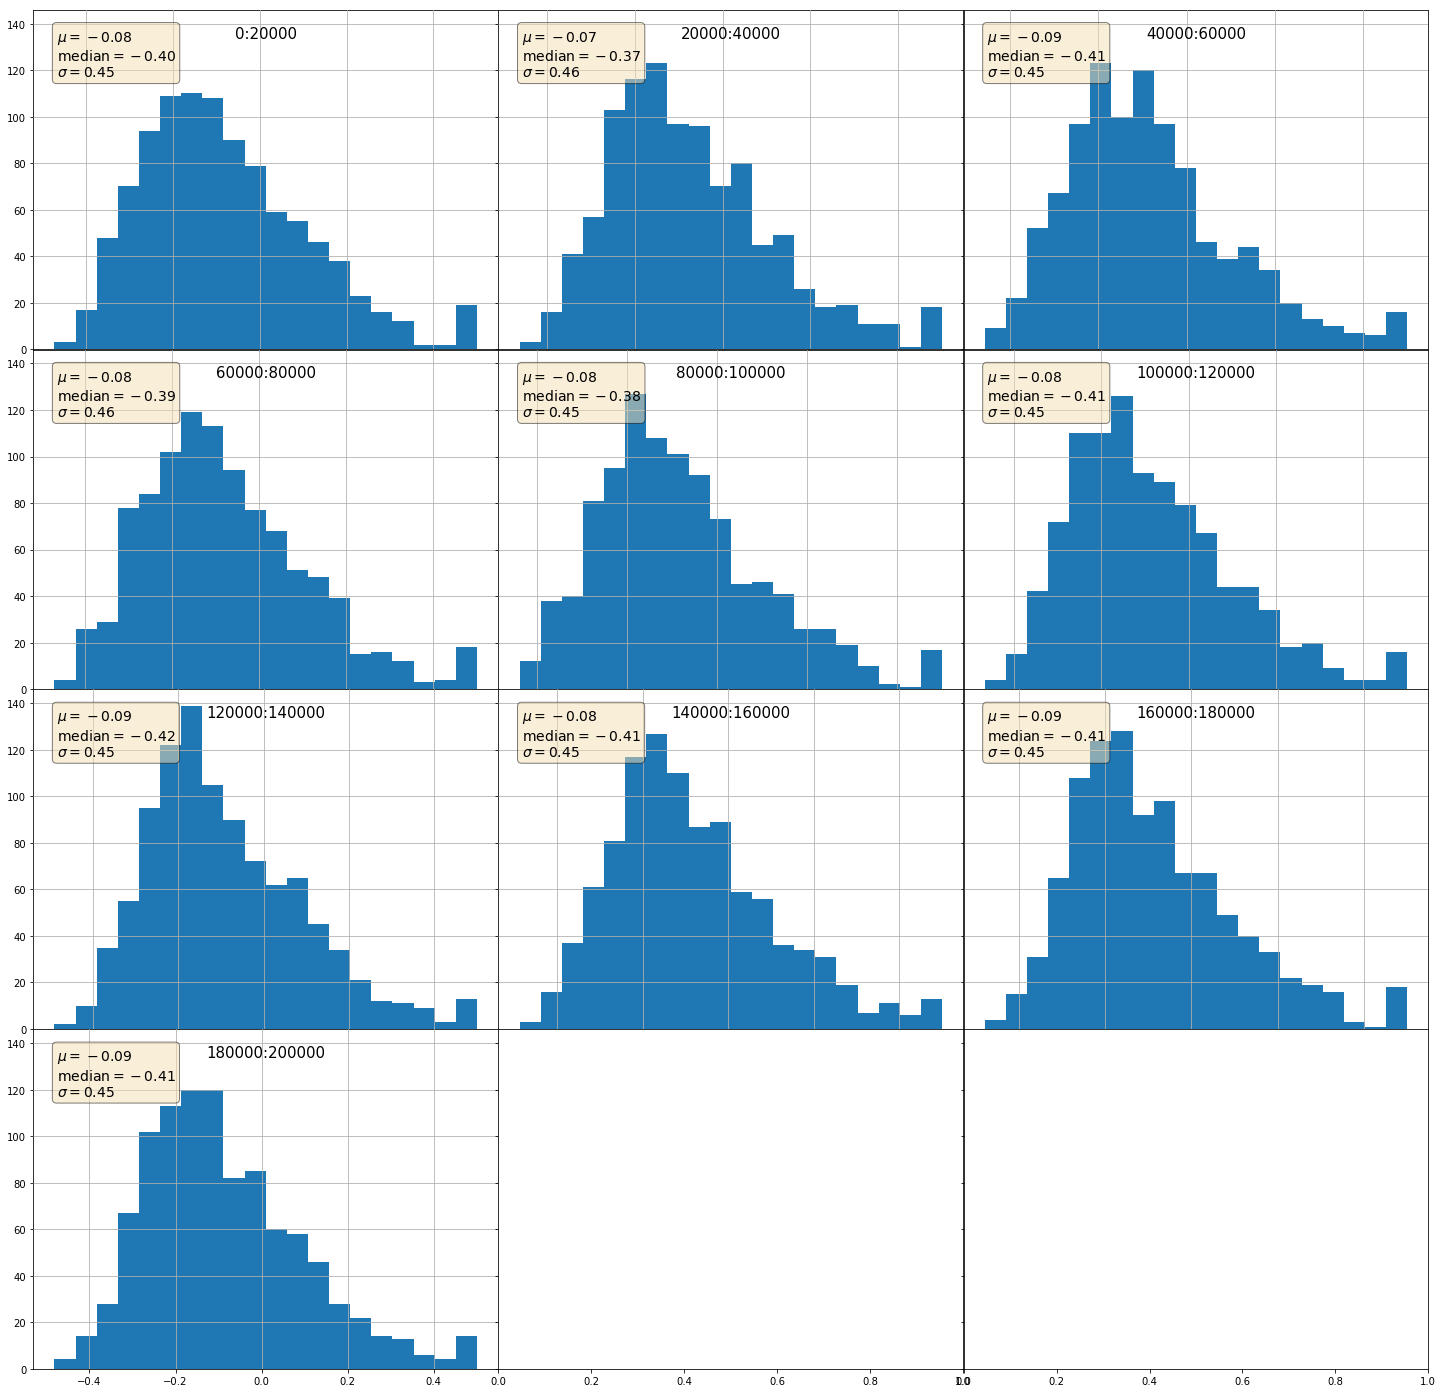

In [45]:
plot_shuffle_data(valid_size/10, valid_dataset)

In [10]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [10]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


In [11]:
from time import time
# ===================================================
#                                     FIND DUPLICATES
# ===================================================
# Inspired by eythian's method for duplicates
# https://discussions.udacity.com/t/assignment-1-problem-5/45657/10
t0 = time()
# Set data to read only so we can create hashes
train_dataset.flags.writeable=False
test_dataset.flags.writeable=False
valid_dataset.flags.writeable=False

# Get hashes for all images as a list (to preserve indices)
train_hashes = [hash(image.data) for image in train_dataset]
test_hashes = [hash(image.data) for image in test_dataset]
valid_hashes = [hash(image.data) for image in valid_dataset]

# Unique set of hashes found in train. And the set of hashes in test and 
# validation that overlap with the hashes the training data
unique_train_hashes = set(train_hashes)
test_overlap_hashes = unique_train_hashes.intersection(set(test_hashes))
valid_overlap_hashes = unique_train_hashes.intersection(set(valid_hashes))

# ---------------------------------------------------
#                                 Create Dictionaries
# ---------------------------------------------------
# Dictionary Keys represent every unique hash from the training data.
# Dictionary Values are lists of indices in the corresponding dataset have that 
# hash.

# Initialise the dictionaries with empty lists
train_hash_dict =  {val: [] for val in unique_train_hashes}
test_hash_dict = {val: [] for val in test_overlap_hashes}
valid_hash_dict = {val: [] for val in valid_overlap_hashes}

# For the train set, append the indices to the corresponding hash
filter(lambda (i,val): train_hash_dict[val].append(i), enumerate(train_hashes))

# For test set, append indices only if the hash overlaps with train set
for i, image_hash in enumerate(test_hashes):
    if image_hash in test_overlap_hashes:
        test_hash_dict[image_hash].append(i)

# The same for the validation set
for i, image_hash in enumerate(valid_hashes):
    if image_hash in valid_overlap_hashes:
        valid_hash_dict[image_hash].append(i)
print("Found Duplicate indices in in", time() - t0, "seconds")

Found Duplicate indices in in 1.30350589752 seconds


In [65]:
# Copy from Udacity forum
import time, hashlib 
def fast_overlaps_num_set_and_hash(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    hash1 = set([hash(image1.data) for image1 in images1])
    hash2 = set([hash(image2.data) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return len(all_overlaps)
def find_dups_and_overlaps(images1, images2):
    images1.flags.writeable=False
    images2.flags.writeable=False
    dup_table={}
    duplicates1 = []
    for idx,img in enumerate(images1):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            duplicates1.append((idx, dup_table[h]))
            #print 'Duplicate image: %d matches %d' % (idx, dup_table[h])
        dup_table[h] = idx
    overlaps = []
    for idx,img in enumerate(images2):
        h = hash(img.data)
        if h in dup_table and (images1[dup_table[h]].data == img.data):
            overlaps.append((dup_table[h], idx))
            #print 'Test image %d is in the training set' % idx
    return duplicates1, overlaps
def num_overlaps_with_diff_labels(overlap_indices, labels1, labels2):
    count = 0
    for olap in overlap_indices:
        if labels1[olap[0]] != labels2[olap[1]]:
            count += 1
    return count
def faster_overlaps_hashlib_and_numpy():
    import hashlib
    train_hashes = [hashlib.sha1(x).digest() for x in train_dataset]
valid_hashes = [hashlib.sha1(x).digest() for x in valid_dataset]
test_hashes  = [hashlib.sha1(x).digest() for x in test_dataset]

valid_in_train = np.in1d(valid_hashes, train_hashes)
test_in_train  = np.in1d(test_hashes,  train_hashes)
test_in_valid  = np.in1d(test_hashes,  valid_hashes)

valid_keep = ~valid_in_train
test_keep  = ~(test_in_train | test_in_valid)

valid_dataset_clean = valid_dataset[valid_keep]
valid_labels_clean  = valid_labels [valid_keep]

test_dataset_clean = test_dataset[test_keep]
test_labels_clean  = test_labels [test_keep]

print("valid -> train overlap: %d samples" % valid_in_train.sum())
print("test  -> train overlap: %d samples" % test_in_train.sum())
print("test  -> valid overlap: %d samples" % test_in_valid.sum())
print('\nMethod 1: hash and check equality')
t1 = time.time()
train_dups, train_valid_overlaps = find_dups_and_overlaps(train_dataset, valid_dataset)
test_dups, test_train_overlaps = find_dups_and_overlaps(test_dataset, train_dataset)
valid_dups, valid_test_overlaps = find_dups_and_overlaps(valid_dataset, test_dataset)
print('train dups: %s, test_dups: %s, valid_dups: %s' \
      % (len(train_dups), len(test_dups), len(valid_dups))) 
print('train/valid overlaps: %s, of which %s have different labels' % \
    (len(train_valid_overlaps), num_overlaps_with_diff_labels(train_valid_overlaps, train_labels, valid_labels))) 
print('test/train overlaps: %s, of which %s have different labels' % \
    (len(test_train_overlaps), num_overlaps_with_diff_labels(test_train_overlaps, test_labels, train_labels)))
print ('valid/test overlaps: %s, of which %s have different labels' % \
    (len(valid_test_overlaps), num_overlaps_with_diff_labels(valid_test_overlaps, valid_labels, test_labels)))
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))
print('\nMethod 2: hash and set')
t1 = time.time()
print('fast train/validation overlaps: %s ' % fast_overlaps_num_set_and_hash(train_dataset, valid_dataset))
print('fast train/test overlaps: %s' % fast_overlaps_num_set_and_hash(train_dataset, test_dataset)) 
print('fast test/validation overlaps: %s' % fast_overlaps_num_set_and_hash(test_dataset, valid_dataset))
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))
print('\nMethod 3: hashlib and numpy')
t1 = time.time()
faster_overlaps_hashlib_and_numpy()
t2 = time.time()
print("Time: %0.2fs" % (t2 - t1))

valid -> train overlap: 0 samples
test  -> train overlap: 0 samples
test  -> valid overlap: 213 samples

Method 1: hash and check equality
train dups: 12715, test_dups: 204, valid_dups: 151
train/valid overlaps: 1060, of which 28 have different labels
test/train overlaps: 3555, of which 94 have different labels
valid/test overlaps: 213, of which 4 have different labels
Time: 1.97s

Method 2: hash and set
fast train/validation overlaps: 929 
fast train/test overlaps: 1156
fast test/validation overlaps: 71
Time: 1.96s

Method 3: hashlib and numpy
Time: 0.95s


In [66]:
import hashlib
import time
from itertools import combinations

start = time.time()

same_set = []
d_sets = [train_dataset, test_dataset, valid_dataset]
d_sets_names = ["train_dataset", "test_dataset", "valid_dataset"]
rep_counts = {}

for i,x in enumerate(d_sets):
    same_set.append(set([hashlib.sha1(image_array).hexdigest() for image_array in x]))
    rep_counts[d_sets_names[i]]= {"orig_len": len(x),
                                  "uniq_len": len(same_set[i]),
                                  "repeat_count" : len(x)-len(same_set[i])}
    
set_pairs = combinations(d_sets,2)
set_pair_names = combinations(d_sets_names,2)

for i, ((first_set_name, second_set_name),(first_set, second_set)) in enumerate(zip(set_pair_names,set_pairs)):
    total_set_lengths = rep_counts[first_set_name]["orig_len"] + rep_counts[second_set_name]["orig_len"]
    total_unique_lens = rep_counts[first_set_name]["uniq_len"] + rep_counts[second_set_name]["uniq_len"]
    final_unique_lens = len(set([hashlib.sha1(image_array).hexdigest() 
                                 for image_array in np.vstack((first_set,second_set))]))

    rep_counts[first_set_name + " " + second_set_name] = {"total_set_lengths": total_set_lengths,
                                                         "total_unique_lens": total_unique_lens,
                                                          "repeat_count": total_unique_lens - final_unique_lens}
for x in [[key,val["repeat_count"]]for key,val in rep_counts.items()]:
    print(x)
print(time.time()-start,"s")

['test_dataset valid_dataset', 71]
['train_dataset test_dataset', 1156]
['train_dataset valid_dataset', 929]
['test_dataset', 204]
['train_dataset', 12715]
['valid_dataset', 151]
8.5627579689 s


In [11]:
from sklearn import linear_model, metrics

reshape_train = np.reshape(train_dataset, (train_dataset.shape[0], \
                                           train_dataset.shape[1]**2))
reshape_valid = np.reshape(valid_dataset, (valid_dataset.shape[0], \
                                           valid_dataset.shape[1]**2))

def mnist_logistic(n_train, train_data, n_valid, valid_data):
    logistic = linear_model.LogisticRegression(C=1e5)
    logistic.fit(train_data[0:n_train], train_labels[0:n_train])
    LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
    expected = valid_labels[0:n_valid]
    predicted = logistic.predict(valid_data[0:n_valid])
    return logistic,expected,predicted

logistic,expected,predicted = mnist_logistic(1000, reshape_train, 100, reshape_valid )    
print("Classification report for classifier %s:\n%s\n"
      % (logistic, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))    

Classification report for classifier LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False):
             precision    recall  f1-score   support

          0       0.44      0.67      0.53         6
          1       0.43      0.60      0.50         5
          2       0.86      1.00      0.92         6
          3       0.64      0.58      0.61        12
          4       0.86      0.67      0.75         9
          5       0.60      0.67      0.63         9
          6       1.00      0.67      0.80         9
          7       0.83      0.62      0.71        16
          8       0.81      0.93      0.87        14
          9       0.73      0.79      0.76        14

avg / total       0.75      0.72      0.72       100


Confusion matrix:
[[ 4  1  0  1  0  0  0  0  0  0]
 

In [12]:
from sklearn.manifold.t_sne import TSNE
# In order to draw 2D, we need to transform the data
X_Train_embedded = TSNE(n_components=2).fit_transform(reshape_train[0:1000])
X_Train_embedded.shape

(1000, 2)

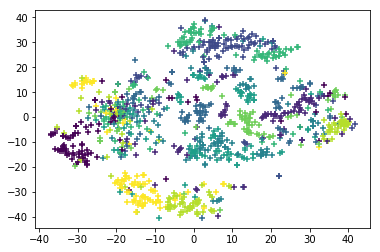

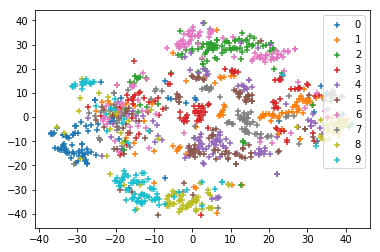

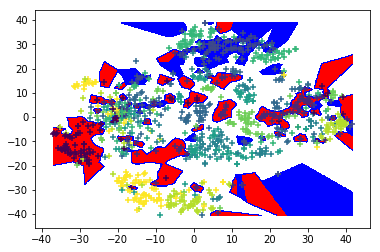

In [113]:
from sklearn.neighbors.classification import KNeighborsClassifier
from matplotlib import colors
from matplotlib import gridspec
import matplotlib as mpl

X,y = reshape_train[0:1000], train_labels[0:1000]
y_predicted = logistic.predict(X)
resolution = 500 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(X_Train_embedded[:,0]), np.max(X_Train_embedded[:,0])
X2d_ymin, X2d_ymax = np.min(X_Train_embedded[:,1]), np.max(X_Train_embedded[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), \
                     np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(X_Train_embedded, y_predicted) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

# plot without legend
cmap = colors.ListedColormap(['r','b','g'])
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], \
           c=y, label=y, marker = '+')
plt.show()

# Try to show legend
a=X_Train_embedded[:,0]
b=X_Train_embedded[:,1]
classes = y
unique = list(set(y))
colors = [plt.cm.jet(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [a[j] for j  in range(len(a)) if classes[j] == u]
    yi = [b[j] for j  in range(len(a)) if classes[j] == u]
    plt.scatter(xi, yi, label=str(u), marker = '+')
plt.legend()
plt.show()

# Boundaries?
plt.contourf(xx, yy, voronoiBackground, cmap = cmap, \
            norm = norm, levels = [0,1,2] )
plt.scatter(X_Train_embedded[:,0], X_Train_embedded[:,1], \
            c=y, marker = '+')
plt.show()